# Cal-CRAI Index Calculation Testing

Note: Functions and figures within this notebook are in development

In [2]:
import pandas as pd
import os
import sys
import numpy as np
import shutil
import glob
import geopandas as gpd
import matplotlib.pyplot as plt

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.index_plot import index_plot
from scripts.utils.calculate_index import handle_outliers, min_max_standardize

## Pulling all calculated metric files

In [3]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, search_zipped=False)

Saved DataFrame as 'built_broadband_internet_metric.csv'
Saved DataFrame as 'built_cellular_towers_metric.csv'
Saved DataFrame as 'built_energy_transmission_lines_metric.csv'
Saved DataFrame as 'built_housing_median_age_metric.csv'
Saved DataFrame as 'built_housing_mobile_homes_metric.csv'
Saved DataFrame as 'built_housing_quality_metric.csv'
Saved DataFrame as 'built_metric_housing_vacancy_metric.csv'
Saved DataFrame as 'built_microwave_towers_metric.csv'
Saved DataFrame as 'built_mobile_towers_metric.csv'
Saved DataFrame as 'built_paging_towers_metric.csv'
Saved DataFrame as 'built_power_plant_metric.csv'
Saved DataFrame as 'built_power_shutoffs_metric.csv'
Saved DataFrame as 'built_radio_towers_metric.csv'
Saved DataFrame as 'built_transportation_airports_metric.csv'
Saved DataFrame as 'built_transportation_bottleneck_metric.csv'
Saved DataFrame as 'built_transportation_bridge_metric.csv'
Saved DataFrame as 'built_transportation_highway_metric.csv'
Saved DataFrame as 'built_transpor

In [4]:
meta_csv = r'C:/Users/jespi/eagle/carb-climate-index-9/metadata/Full Data Pipeline Notes - 4_ Calculate Metric.csv'
# read in first tab of the sheet
df = pd.read_csv(meta_csv)
df.columns

Index(['Data Source', 'Data', 'Domain', 'Indicator', 'Metric',
       'High value result (vulnerable or resilient)', 'Metric file name',
       'Metric Calculated (Y/N)', 'Metadata Finalized (Y/N)',
       'Metric Calculator', 'Metric goes into what indicator',
       'Includes Indigenous Tribes', 'Notes'],
      dtype='object')

## Selecting files specifically for governance domain

In [5]:
# Define the output folder path
output_folder = 'output_folder'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load the metadata CSV
meta_csv = r'C:/Users/jespi/eagle/carb-climate-index-9/metadata/Full Data Pipeline Notes - 4_ Calculate Metric.csv'
df = pd.read_csv(meta_csv)

# Get the list of metric file names and corresponding 'High value result' entries
metric_files = df[['Metric file name', 'High value result (vulnerable or resilient)']]

# Find all CSV files starting with 'governance_' and matching the metric file names
source_files = [file for file in glob.glob('governance_*.csv') if os.path.basename(file) in metric_files['Metric file name'].values]

# Iterate through the source files and process them
for file in source_files:
    # Get the 'High value result (vulnerable or resilient)' entry for the current file
    column_result = metric_files.loc[metric_files['Metric file name'] == os.path.basename(file), 'High value result (vulnerable or resilient)'].values[0]
    
    # Load the CSV file
    csv_df = pd.read_csv(file)
    
    # Get the last column name
    last_column = csv_df.columns[-1]
    
    # Append the column result to the last column name
    csv_df.rename(columns={last_column: f"{last_column}_{column_result}"}, inplace=True)
    
    # Construct the destination file path
    destination_path = os.path.join(output_folder, os.path.basename(file))
    
    # Save the modified CSV to the output folder
    csv_df.to_csv(destination_path, index=False)
    
    # Remove the original file
    os.remove(file)

print(f"Processed and removed {len(source_files)} CSV files.")

# Delete all CSV files in the current directory that are not in the output folder
current_files = glob.glob('*.csv')
for file in current_files:
    if file not in [os.path.basename(f) for f in source_files]:
        os.remove(file)

print(f"Deleted {len(current_files) - len(source_files)} local CSV files.")

Processed and removed 12 CSV files.
Deleted 101 local CSV files.


## Placing relevant files in a folder and removing others

In [11]:
# Define the output folder path
output_folder = 'output_folder'

# Get a list of all CSV files in the output folder
csv_files = glob.glob(os.path.join(output_folder, '*.csv'))

# Initialize an empty DataFrame for merging
merged_df = pd.DataFrame()
# Iterate through each CSV file and merge them on the 'census_tract' column
for file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Rename 'GEO_ID' or 'tract' to 'census_tract' if they exist
    if 'USCB_GEOID' in df.columns:
        df.rename(columns={'USCB_GEOID': 'census_tract'}, inplace=True)
    elif 'GEO_ID' in df.columns:
        df.rename(columns={'GEO_ID': 'census_tract'}, inplace=True)
    elif 'tract' in df.columns:
        df.rename(columns={'tract': 'census_tract'}, inplace=True)
    elif 'TRACT' in df.columns:
        df.rename(columns={'TRACT': 'census_tract'}, inplace=True)
    elif 'Census_Tract' in df.columns:
        df.rename(columns={'Census_Tract': 'census_tract'}, inplace=True)

    # Convert 'census_tract' to string to ensure consistent data type
    df['census_tract'] = df['census_tract'].astype(str)

    # Keep only the 'census_tract' and the last column from each file
    last_column = df.columns[-1]
    df = df[['census_tract', last_column]]
    
    # Merge the DataFrame with the existing merged DataFrame
    if merged_df.empty:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df, on='census_tract', how='outer')

# Save the merged DataFrame to a CSV file
merged_df.to_csv('concatenate_governance_metrics.csv', index=False)

print(f"Merged CSV saved as concatenate_governance_metrics.csv")

Merged CSV saved as concatenate_governance_metrics.csv


In [12]:
merged_df.columns

Index(['census_tract', 'num_fire_stations_per_10000_people_resilient',
       'num_flood_policies_resilient',
       'total_fuel_reduction_acres_planned_resilient',
       'housing_units_with_morgage_resilient', 'NTMP_Percentage_resilient'],
      dtype='object')

In [13]:
merged_df

,census_tract,num_fire_stations_per_10000_people_resilient,num_flood_policies_resilient,total_fuel_reduction_acres_planned_resilient,housing_units_with_morgage_resilient,NTMP_Percentage_resilient
0,6001400100,0.552943,2642.0,NaN,68.7%,NaN
1,6001400200,0.552943,2642.0,NaN,68.7%,NaN
2,6001400300,0.552943,2642.0,NaN,68.7%,NaN
3,6001400400,0.552943,2642.0,NaN,68.7%,NaN
4,6001400500,0.552943,2642.0,NaN,68.7%,NaN
...,...,...,...,...,...,...
9124,6115040902,1.468698,586.0,NaN,67.5%,0.573947
9125,6115041001,1.468698,586.0,NaN,67.5%,0.573947
9126,6115041002,1.468698,586.0,NaN,67.5%,0.573947
9127,6115041101,1.468698,586.0,NaN,67.5%,0.573947


In [38]:
governance_metrics = pd.read_csv('concatenate_governance_metrics.csv')

# Drop rows where 'census_tract' is NaN
governance_metrics = governance_metrics.dropna(subset=['census_tract'])

# Convert census tract to string and eliminate scientific notation default
governance_metrics['census_tract'] = governance_metrics['census_tract'].dropna().apply(lambda x: '{:.0f}'.format(x))

# Convert all values within the island tract (near San Francisco) to nan, as it is uninhabited 
island_tract = '6075980401'
governance_metrics.loc[governance_metrics['census_tract'] == island_tract, 
                            governance_metrics.columns != 'census_tract'] = np.nan

# Identify columns with percentage data (assuming they contain '%' in the values)
percentage_columns = governance_metrics.columns[governance_metrics.applymap(lambda x: isinstance(x, str) and '%' in x).any()]

# Convert percentage columns to numeric
for col in percentage_columns:
    governance_metrics[col] = governance_metrics[col].replace('%', '', regex=True).astype(float)

governance_metrics

C:\Users\jespi\AppData\Local\Temp\ipykernel_34396\662850274.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  percentage_columns = governance_metrics.columns[governance_metrics.applymap(lambda x: isinstance(x, str) and '%' in x).any()]


,census_tract,num_fire_stations_per_10000_people_resilient,num_flood_policies_resilient,total_fuel_reduction_acres_planned_resilient,housing_units_with_morgage_resilient,NTMP_Percentage_resilient
0,6001400100,0.552943,2642.0,NaN,68.7,NaN
1,6001400200,0.552943,2642.0,NaN,68.7,NaN
2,6001400300,0.552943,2642.0,NaN,68.7,NaN
3,6001400400,0.552943,2642.0,NaN,68.7,NaN
4,6001400500,0.552943,2642.0,NaN,68.7,NaN
...,...,...,...,...,...,...
9124,6115040902,1.468698,586.0,NaN,67.5,0.573947
9125,6115041001,1.468698,586.0,NaN,67.5,0.573947
9126,6115041002,1.468698,586.0,NaN,67.5,0.573947
9127,6115041101,1.468698,586.0,NaN,67.5,0.573947


In [39]:
# Make sure all columns within the island tract are NaN
checking_island_tract = governance_metrics[governance_metrics['census_tract']=='6075980401']
checking_island_tract

,census_tract,num_fire_stations_per_10000_people_resilient,num_flood_policies_resilient,total_fuel_reduction_acres_planned_resilient,housing_units_with_morgage_resilient,NTMP_Percentage_resilient
7295,6075980401,NaN,NaN,NaN,NaN,NaN


## Checking to see if there are infinite values within our columns
* if so, replacing infinite values with NaN

In [40]:
# Selecting only numeric columns
numeric_df = governance_metrics.select_dtypes(include=[np.number])

# Counting infinite values
num_infinite = np.isinf(numeric_df).sum().sum()

print(f"\nNumber of infinite entries in the DataFrame: {num_infinite}")


Number of infinite entries in the DataFrame: 0


In [41]:
# Replace infinite values with NaN
governance_metrics.replace([np.inf, -np.inf], np.nan, inplace=True)

# Selecting only numeric columns
numeric_df = governance_metrics.select_dtypes(include=[np.number])

# Counting infinite values
num_infinite = np.isinf(numeric_df).sum().sum()

print(f"\nNumber of infinite entries in the DataFrame: {num_infinite}")


Number of infinite entries in the DataFrame: 0


## Call outlier function to handle outliers:
Max = 3 x 75th percentile
Min = -3 x 25th percentile

Outliers beyond these values are set to metric value closest to the fence
Baum et al. 1970

In [42]:
# Handle outliers
handle_outlier_csv = 'no_outlier_governance_metrics.csv'
output = handle_outliers(governance_metrics, handle_outlier_csv)
print(f"Processed and saved {handle_outlier_csv} with outlier handling.")

For column num_fire_stations_per_10000_people_resilient:
  Q1 (25th percentile): 0.3783956226872328
  Q3 (75th percentile): 0.6726336252857315
  IQR: 0.29423800259849864
  Max fence: 2.0179008758571944
  Min fence: -1.1351868680616986
Outliers detected in column 'num_fire_stations_per_10000_people_resilient':
census_tract: 6003010000, value: 6.600660066006601
census_tract: 6009000121, value: 2.627315321627184
census_tract: 6009000122, value: 2.627315321627184
census_tract: 6009000123, value: 2.627315321627184
census_tract: 6009000124, value: 2.627315321627184
census_tract: 6009000220, value: 2.627315321627184
census_tract: 6009000221, value: 2.627315321627184
census_tract: 6009000222, value: 2.627315321627184
census_tract: 6009000301, value: 2.627315321627184
census_tract: 6009000302, value: 2.627315321627184
census_tract: 6009000400, value: 2.627315321627184
census_tract: 6009000501, value: 2.627315321627184
census_tract: 6009000504, value: 2.627315321627184
census_tract: 6009000505, 

In [43]:
# viewing new 'fenced' outliers
no_outlier_governance_metrics = pd.read_csv('no_outlier_governance_metrics.csv')
no_outlier_governance_metrics

,census_tract,num_fire_stations_per_10000_people_resilient,num_flood_policies_resilient,total_fuel_reduction_acres_planned_resilient,housing_units_with_morgage_resilient,NTMP_Percentage_resilient
0,6001400100,0.552943,2642.0,NaN,68.7,NaN
1,6001400200,0.552943,2642.0,NaN,68.7,NaN
2,6001400300,0.552943,2642.0,NaN,68.7,NaN
3,6001400400,0.552943,2642.0,NaN,68.7,NaN
4,6001400500,0.552943,2642.0,NaN,68.7,NaN
...,...,...,...,...,...,...
9124,6115040902,1.468698,586.0,NaN,67.5,0.573947
9125,6115041001,1.468698,586.0,NaN,67.5,0.573947
9126,6115041002,1.468698,586.0,NaN,67.5,0.573947
9127,6115041101,1.468698,586.0,NaN,67.5,0.573947


## Metrics are now min-max standardized on 0.01 to 0.99 scale

In [44]:
# standardizing our df
min_max_metrics = no_outlier_governance_metrics.copy()
columns_to_process = [col for col in min_max_metrics.columns if col != 'census_tract']
min_max_metrics = min_max_standardize(min_max_metrics, columns_to_process)

min_max_metrics.head()

,census_tract,num_fire_stations_per_10000_people_resilient_min,num_fire_stations_per_10000_people_resilient_max,num_fire_stations_per_10000_people_resilient_min_max_standardized,num_flood_policies_resilient_min,num_flood_policies_resilient_max,num_flood_policies_resilient_min_max_standardized,total_fuel_reduction_acres_planned_resilient_min,total_fuel_reduction_acres_planned_resilient_max,total_fuel_reduction_acres_planned_resilient_min_max_standardized,housing_units_with_morgage_resilient_min,housing_units_with_morgage_resilient_max,housing_units_with_morgage_resilient_min_max_standardized,NTMP_Percentage_resilient_min,NTMP_Percentage_resilient_max,NTMP_Percentage_resilient_min_max_standardized
0,6001400100,0.378396,2.017901,0.106464,0.0,20128.0,0.13126,0.5,1389.0,NaN,52.6,73.4,0.774038,0.028079,1.721842,NaN
1,6001400200,0.378396,2.017901,0.106464,0.0,20128.0,0.13126,0.5,1389.0,NaN,52.6,73.4,0.774038,0.028079,1.721842,NaN
2,6001400300,0.378396,2.017901,0.106464,0.0,20128.0,0.13126,0.5,1389.0,NaN,52.6,73.4,0.774038,0.028079,1.721842,NaN
3,6001400400,0.378396,2.017901,0.106464,0.0,20128.0,0.13126,0.5,1389.0,NaN,52.6,73.4,0.774038,0.028079,1.721842,NaN
4,6001400500,0.378396,2.017901,0.106464,0.0,20128.0,0.13126,0.5,1389.0,NaN,52.6,73.4,0.774038,0.028079,1.721842,NaN


## Now isolating for census tract and standardized columns exclusively

In [45]:
words = ['census_tract','standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.contains(word)].tolist())

min_max_standardized_governance_metrics_df = min_max_metrics[selected_columns]
pd.set_option('display.max_columns', None)

min_max_standardized_governance_metrics_df

,census_tract,num_fire_stations_per_10000_people_resilient_min_max_standardized,num_flood_policies_resilient_min_max_standardized,total_fuel_reduction_acres_planned_resilient_min_max_standardized,housing_units_with_morgage_resilient_min_max_standardized,NTMP_Percentage_resilient_min_max_standardized
0,6001400100,0.106464,0.131260,NaN,0.774038,NaN
1,6001400200,0.106464,0.131260,NaN,0.774038,NaN
2,6001400300,0.106464,0.131260,NaN,0.774038,NaN
3,6001400400,0.106464,0.131260,NaN,0.774038,NaN
4,6001400500,0.106464,0.131260,NaN,0.774038,NaN
...,...,...,...,...,...,...
9124,6115040902,0.665019,0.029114,NaN,0.716346,0.322281
9125,6115041001,0.665019,0.029114,NaN,0.716346,0.322281
9126,6115041002,0.665019,0.029114,NaN,0.716346,0.322281
9127,6115041101,0.665019,0.029114,NaN,0.716346,0.322281


## Now need to refactor metrics where high values indicate resistance
* subtract resilient columns values from 1

In [49]:
# Select columns with 'resilient' in their names
resilient_columns = [col for col in min_max_standardized_governance_metrics_df.columns if 'resilient' in col]

# Use .loc to ensure you're modifying the DataFrame correctly
min_max_standardized_governance_metrics_df.loc[:, resilient_columns] = 1 - min_max_standardized_governance_metrics_df.loc[:, resilient_columns]

In [50]:
min_max_standardized_governance_metrics_df

,census_tract,num_fire_stations_per_10000_people_resilient_min_max_standardized,num_flood_policies_resilient_min_max_standardized,total_fuel_reduction_acres_planned_resilient_min_max_standardized,housing_units_with_morgage_resilient_min_max_standardized,NTMP_Percentage_resilient_min_max_standardized
0,6001400100,0.893536,0.868740,NaN,0.225962,NaN
1,6001400200,0.893536,0.868740,NaN,0.225962,NaN
2,6001400300,0.893536,0.868740,NaN,0.225962,NaN
3,6001400400,0.893536,0.868740,NaN,0.225962,NaN
4,6001400500,0.893536,0.868740,NaN,0.225962,NaN
...,...,...,...,...,...,...
9124,6115040902,0.334981,0.970886,NaN,0.283654,0.677719
9125,6115041001,0.334981,0.970886,NaN,0.283654,0.677719
9126,6115041002,0.334981,0.970886,NaN,0.283654,0.677719
9127,6115041101,0.334981,0.970886,NaN,0.283654,0.677719


In [53]:
# testing to see how to average all df columns together barring census tract to calculate indicator score
testing = pd.DataFrame()
testing['census_tract'] = min_max_standardized_governance_metrics_df['census_tract']
testing['average'] = min_max_standardized_governance_metrics_df.drop(columns=['census_tract']).mean(axis=1)

testing

,census_tract,average
0,6001400100,0.662746
1,6001400200,0.662746
2,6001400300,0.662746
3,6001400400,0.662746
4,6001400500,0.662746
...,...,...
9124,6115040902,0.566810
9125,6115041001,0.566810
9126,6115041002,0.566810
9127,6115041101,0.566810


In [54]:
min_max_standardized_governance_metrics_df.columns

Index(['census_tract',
       'num_fire_stations_per_10000_people_resilient_min_max_standardized',
       'num_flood_policies_resilient_min_max_standardized',
       'total_fuel_reduction_acres_planned_resilient_min_max_standardized',
       'housing_units_with_morgage_resilient_min_max_standardized',
       'NTMP_Percentage_resilient_min_max_standardized'],
      dtype='object')

## Dictionary to associate a keyword within the df column with its indicator

In [55]:
metric_to_indicator_dict = {
    'emergency_response' :           ['fire_stations',
                                ],

    'personal_preparedness' : ['flood_policies',
                                'morgage'],

    'community_preparedness' :          ['fuel_reduction'
                                ],

    'natural_resource_conservation' :               ['NTMP'
                                 ]
}

# Loop to go through df columns and average metrics that belong within an indicator based off of the metric to indicator dictionary

In [56]:
# Create an empty DataFrame to store the results
averaged_indicators_governance = pd.DataFrame()

# Iterate through the items of the dictionary
for indicator, keywords in metric_to_indicator_dict.items():
    # Filter columns based on the keyword values for the current indicator
    indicator_columns = [col for col in min_max_standardized_governance_metrics_df.columns if any(keyword in col for keyword in keywords)]
    
    # Compute the average of the selected columns
    averaged_values = min_max_standardized_governance_metrics_df[indicator_columns].mean(axis=1)
    print(indicator_columns)
    print(len(indicator_columns))
    # Store the averaged values in the result DataFrame with the indicator name as the column name
    averaged_indicators_governance[indicator] = averaged_values
    
# Include the 'census_tract' column from the original DataFrame
averaged_indicators_governance['census_tract'] = min_max_standardized_governance_metrics_df['census_tract']
# Reorder the columns to have 'census_tract' as the first column

averaged_indicators_governance = averaged_indicators_governance[['census_tract'] + [col for col in averaged_indicators_governance.columns if col != 'census_tract']]
# Show the resulting DataFrame
print(averaged_indicators_governance)


['num_fire_stations_per_10000_people_resilient_min_max_standardized']
1
['num_flood_policies_resilient_min_max_standardized', 'housing_units_with_morgage_resilient_min_max_standardized']
2
['total_fuel_reduction_acres_planned_resilient_min_max_standardized']
1
['NTMP_Percentage_resilient_min_max_standardized']
1
      census_tract  emergency_response  personal_preparedness  \
0       6001400100            0.893536               0.547351   
1       6001400200            0.893536               0.547351   
2       6001400300            0.893536               0.547351   
3       6001400400            0.893536               0.547351   
4       6001400500            0.893536               0.547351   
...            ...                 ...                    ...   
9124    6115040902            0.334981               0.627270   
9125    6115041001            0.334981               0.627270   
9126    6115041002            0.334981               0.627270   
9127    6115041101            0.3349

## Sum all the non-census tract columns together to calculate the domain score

In [57]:
# Create a new DataFrame to store the results
summed_indicators_governance = pd.DataFrame()

# Calculate the sum of all columns except 'census_tract'
columns_to_process = [col for col in averaged_indicators_governance.columns if col != 'census_tract']

summed_values = averaged_indicators_governance[columns_to_process].sum(axis=1)

# Store the summed values in the result DataFrame with the column name 'summed_indicators_governance_domain'
summed_indicators_governance['summed_indicators_governance_domain'] = summed_values

# Include the 'census_tract' column from the original DataFrame
summed_indicators_governance['census_tract'] = averaged_indicators_governance['census_tract']

# Reorder the columns to have 'census_tract' as the first column
summed_indicators_governance = summed_indicators_governance[['census_tract', 'summed_indicators_governance_domain']]

# Show the resulting DataFrame
print(summed_indicators_governance)
print('min value:', summed_indicators_governance.summed_indicators_governance_domain.min())
print('max value:', summed_indicators_governance.summed_indicators_governance_domain.max())

      census_tract  summed_indicators_governance_domain
0       6001400100                             1.440887
1       6001400200                             1.440887
2       6001400300                             1.440887
3       6001400400                             1.440887
4       6001400500                             1.440887
...            ...                                  ...
9124    6115040902                             1.639969
9125    6115041001                             1.639969
9126    6115041002                             1.639969
9127    6115041101                             1.639969
9128    6115041102                             1.639969

[9129 rows x 2 columns]
min value: 0.0
max value: 3.0569141299152265


## Min-max standardize the summed columns

In [58]:
min_max_domain = summed_indicators_governance.copy()

columns_to_process = [col for col in min_max_domain.columns if col != 'census_tract']

min_max_domain = min_max_standardize(min_max_domain, columns_to_process)
print(len(min_max_domain))
min_max_domain.head()

9129


,census_tract,summed_indicators_governance_domain_min,summed_indicators_governance_domain_max,summed_indicators_governance_domain_min_max_standardized
0,6001400100,0.0,3.056914,0.471353
1,6001400200,0.0,3.056914,0.471353
2,6001400300,0.0,3.056914,0.471353
3,6001400400,0.0,3.056914,0.471353
4,6001400500,0.0,3.056914,0.471353


## Isolate to census tract and summed standardized columns, and rename tract to GEOID for merging
* add a zero at the beginning of the GEOID to match census tract that will be merged

In [59]:
min_max_standardized_governance_domain = min_max_domain[['census_tract', 'summed_indicators_governance_domain_min_max_standardized']]
min_max_standardized_governance_domain = min_max_standardized_governance_domain.dropna(subset=['census_tract'])
min_max_standardized_governance_domain = min_max_standardized_governance_domain.rename(columns={'census_tract':'GEOID'})
min_max_standardized_governance_domain['GEOID'] = min_max_standardized_governance_domain['GEOID'].apply(lambda x: '0' + str(x))
min_max_standardized_governance_domain['GEOID'] = min_max_standardized_governance_domain['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

# Print the DataFrame to check the 'GEOID' column
print(len(min_max_standardized_governance_domain))
min_max_standardized_governance_domain

9129


,GEOID,summed_indicators_governance_domain_min_max_standardized
0,06001400100,0.471353
1,06001400200,0.471353
2,06001400300,0.471353
3,06001400400,0.471353
4,06001400500,0.471353
...,...,...
9124,06115040902,0.536479
9125,06115041001,0.536479
9126,06115041002,0.536479
9127,06115041101,0.536479


## Calling census tract shape files so we can reproject and map our data

In [62]:
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries['GEOID'] = ca_boundaries['GEOID'].astype(str)
ca_boundaries.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,085,504321,06085504321,5043.21,Census Tract 5043.21,G5020,S,1450237,0,+37.3931319,-121.8651427,"POLYGON ((-121.87556 37.39924, -121.87535 37.3..."
1,06,085,504410,06085504410,5044.10,Census Tract 5044.10,G5020,S,1102136,0,+37.4093719,-121.8788884,"POLYGON ((-121.88886 37.40758, -121.88576 37.4..."
2,06,085,507003,06085507003,5070.03,Census Tract 5070.03,G5020,S,9529865,0,+37.2199936,-121.9979512,"POLYGON ((-122.02489 37.21683, -122.02459 37.2..."
3,06,085,507004,06085507004,5070.04,Census Tract 5070.04,G5020,S,2424447,0,+37.2260144,-121.9763816,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,06,085,502204,06085502204,5022.04,Census Tract 5022.04,G5020,S,331145,0,+37.3013832,-121.9258424,"POLYGON ((-121.93167 37.29803, -121.92801 37.3..."


## Merge the df and census tracts and convert the geometry to our uniformly used coordinate reference system (4269)
* Map it!

Number of invalid geometries: 0


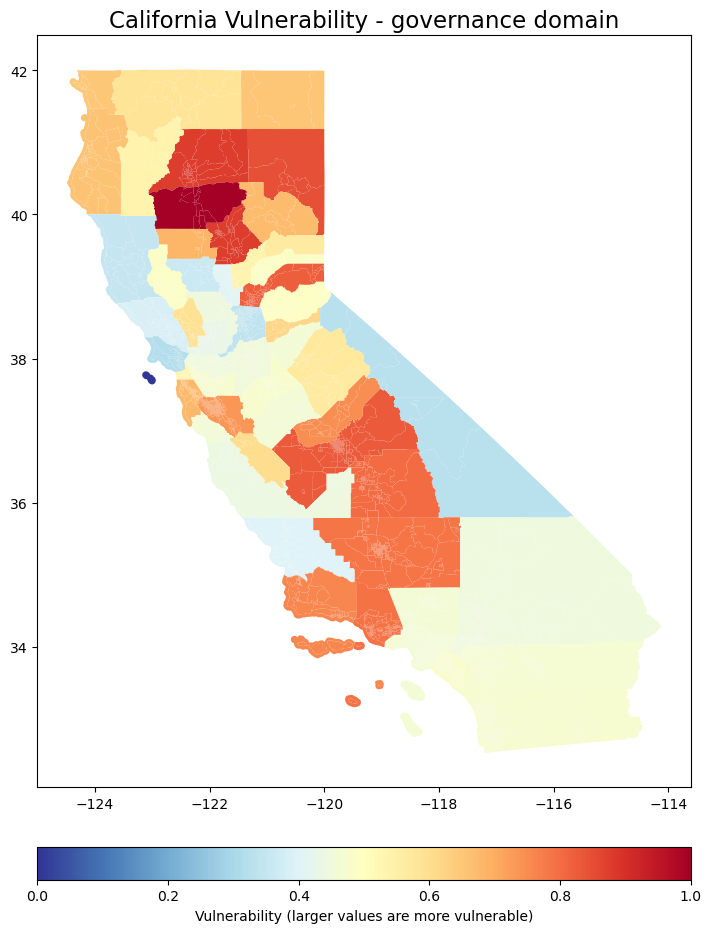

In [63]:
# Merge the DataFrames
df2 = min_max_standardized_governance_domain.merge(ca_boundaries, on='GEOID')

# Convert to GeoDataFrame with the correct CRS
df2 = gpd.GeoDataFrame(df2, geometry='geometry', crs=4269)

# Check for invalid geometries
invalid_geometries = df2[~df2['geometry'].is_valid]
print("Number of invalid geometries:", len(invalid_geometries))

# Check if there are any geometries left
if len(df2) == 0:
    print("No valid geometries remaining. Cannot plot.")
else:
    # Set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(7, 10), layout='compressed')

    # Plot the data
    plot = df2.plot(column='summed_indicators_governance_domain_min_max_standardized', 
             ax=ax, 
             vmin=0, vmax=1, 
             legend=True, 
             cmap='RdYlBu_r',
             legend_kwds={'label': 'Vulnerability (larger values are more vulnerable)', 'orientation': 'horizontal', 'shrink': 1.0, 'pad': 0.03})
    
     # Set title
    ax.set_title('California Vulnerability - governance domain', fontsize = 16.5)

    # Display the plot
    plt.show()


In [64]:
df2.to_csv('governance_index_data.csv', index=False)

In [66]:
bucket_name = 'ca-climate-index'
directory = '3_fair_data/domain_standardized_data'

upload_csv_aws(['governance_index_data.csv'], bucket_name, directory)

governance_index_data.csv uploaded to AWS


## Selecting counties to be mapped, by the COUNTYFP number
* manually enter the names of the counties linked with their number

Number of invalid geometries: 0


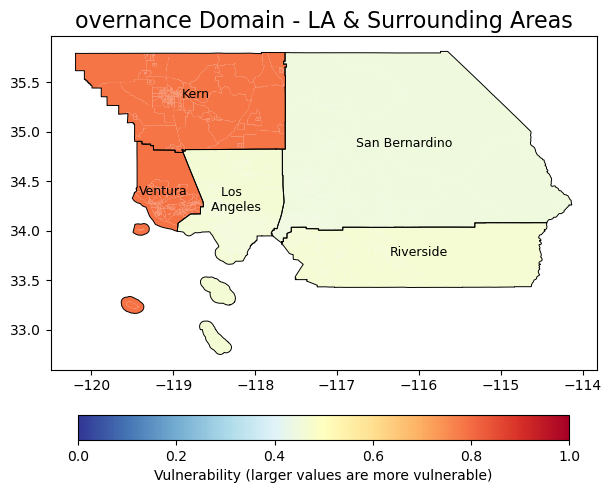

In [65]:
list_of_counties = [
    '037',
    '071',
    '065',
    '029',
    '111']

df2 = min_max_standardized_governance_domain.merge(ca_boundaries, on='GEOID')

# Filtering rows where COUNTYFP is in the list_of_counties
df2_filtered = df2[df2['COUNTYFP'].isin(list_of_counties)]

# Convert to GeoDataFrame with the correct CRS
df2_filtered = gpd.GeoDataFrame(df2_filtered, geometry='geometry', crs=4269)

# Check for invalid geometries
invalid_geometries = df2_filtered[~df2_filtered['geometry'].is_valid]
print("Number of invalid geometries:", len(invalid_geometries))

# Group by COUNTYFP and take the geometry of the first row in each group
county_boundaries = df2_filtered.dissolve(by='COUNTYFP')['geometry']

# Dictionary mapping county codes to labels
county_labels = {
    '037': 'Los \n Angeles',
    '071': 'San Bernardino',
    '065': 'Riverside',
    '029': 'Kern',
    '111': 'Ventura'
}

# Set up the figure
fig, ax = plt.subplots(1, 1, figsize=(6, 12), layout='compressed')

# Plot county boundaries
county_boundaries.boundary.plot(ax=ax, linewidth=0.7, edgecolor='black')

# Plot the data
df2_filtered.plot(column='summed_indicators_governance_domain_min_max_standardized', 
         ax=ax, 
         vmin=0, vmax=1, 
         legend=True, 
         cmap='RdYlBu_r', 
         legend_kwds={'label': 'Vulnerability (larger values are more vulnerable)', 'orientation': 'horizontal', 'shrink': 0.9, 'pad': -0.3})

# Add county labels
for county_code, label in county_labels.items():
    centroid = county_boundaries[county_code].centroid
    ax.text(centroid.x, centroid.y, label, weight='light', fontsize=9, ha='center', va='baseline')

ax.set_title('Governance Domain - LA & Surrounding Areas', fontsize=16)

# Display the plot
plt.show()